In [229]:
import numpy as np
import pyreaper
import scipy
from scipy.signal import find_peaks
from statsmodels.tsa.stattools import acf as sm_acf
import matplotlib.pyplot as plt
import scipy.io.wavfile as wavfile

### 3.1 Создать звуковой файл формата .wav ✅

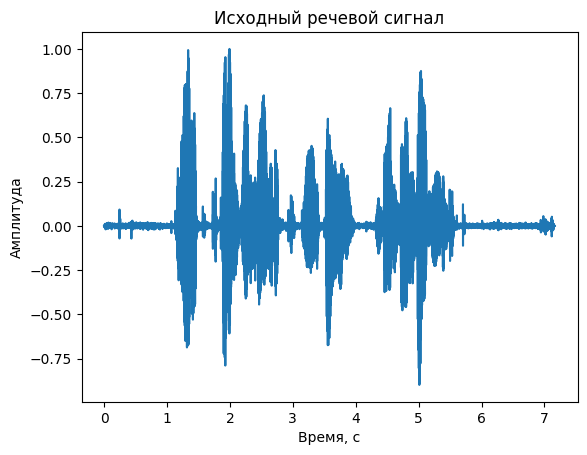

Частота дискретизации: 48000 Гц
Длина сигнала (в отсчётах): 344064
Длительность (в секундах): 7.168


In [230]:
fs, x = wavfile.read("input.wav")

# Если стерео — берём только один канал
if x.ndim > 1:
    x = x[:, 0]

# Нормализация
x = x.astype(np.float32)
x = x / np.max(np.abs(x))

t = np.linspace(0, len(x) / fs, len(x))
plt.figure()
plt.plot(t, x)
plt.title("Исходный речевой сигнал")
plt.xlabel("Время, с")
plt.ylabel("Амплитуда")
plt.show()
print("Частота дискретизации:", fs, "Гц")
print("Длина сигнала (в отсчётах):", len(x))
print("Длительность (в секундах):", len(x)/fs)

### 3.2 Оценка основного тона на основе АКФ

#### Step 1 

In [231]:
def my_acf(x, m):
    """
    Функция для вычисления АКФ для заданного m.
    
    :param x: Сигнал
    :param m: Аргумент для АКФ
    :return: Значение АКФ для m
    """
    x_mean = np.mean(x)
    N = len(x)
    return np.sum((x[:N-m] - x_mean) * (x[m:] - x_mean)) / np.sum((x - x_mean) ** 2)


m = 0, my_acf = 0.000026, statsmodels = 1.000000
m = 1, my_acf = 0.000026, statsmodels = 0.991368
m = 2, my_acf = 0.000026, statsmodels = 0.981444
m = 10, my_acf = 0.000025, statsmodels = 0.933707
m = 20, my_acf = 0.000022, statsmodels = 0.835959
m = 50, my_acf = 0.000010, statsmodels = 0.380398


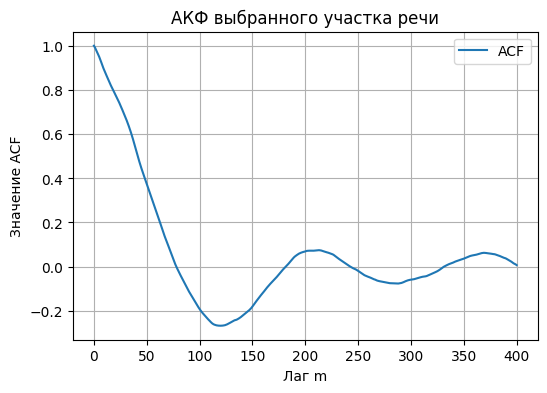

In [242]:
# Чтобы не ждать долго, допустим, возьмём 0.5 секунды с середины сигнала, 
# где точно есть звук. Индексы можно подобрать руками или найти автоматически.
start_sec = 0.5
duration_sec = 0.5
start_index = int(start_sec * fs)
end_index = int(start_index + duration_sec * fs)
x_seg = x[start_index:end_index]

# Вычислим АКФ. Параметр nlags - максимальное значение m,
# которое имеет смысл смотреть. Предположим, что частота тона не упадёт
# ниже 40 Гц (период ~ 25 мс), при fs = 16000 это ~ 400 отсчётов. 
# Подстраиваемся под вашу fs.
nlags = 400
acf_vals = sm_acf(x_seg, adjusted=True, nlags=nlags)

# Построим график АКФ
plt.figure(figsize=(6,4))
plt.plot(acf_vals, label='ACF')
plt.title("АКФ выбранного участка речи")
plt.xlabel("Лаг m")
plt.ylabel("Значение ACF")
plt.legend()
plt.grid(True)
plt.show()

#### Step 2
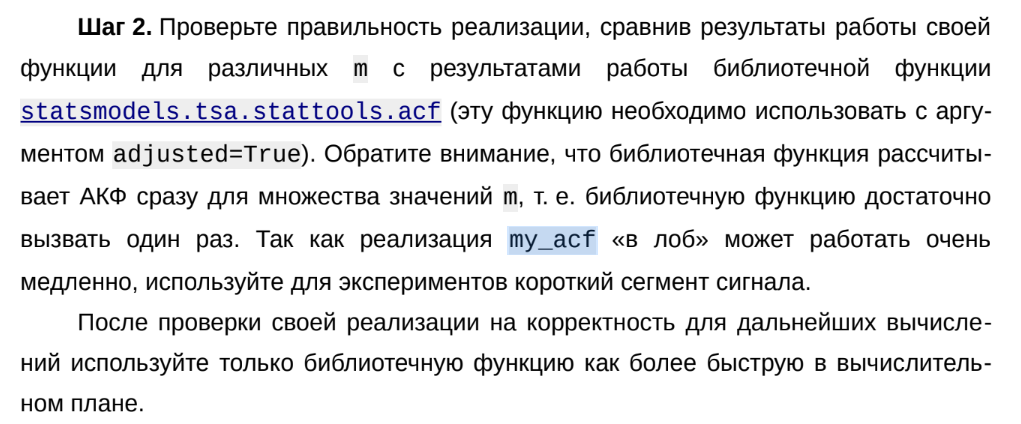

In [233]:

my_acfs = np.array([my_acf(x, m) for m in range(100)])
lib_acfs = sm_acf(x, nlags=99, adjusted=True)

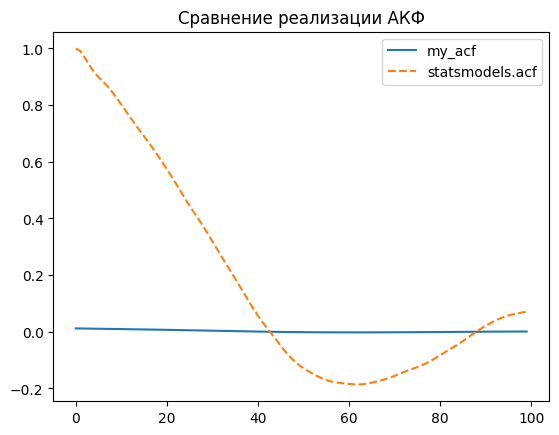

In [234]:
plt.plot(my_acfs, label="my_acf")
plt.plot(lib_acfs, label="statsmodels.acf", linestyle="dashed")
plt.legend()
plt.title("Сравнение реализации АКФ")
plt.show()

#### Step 3 
Постройте график АКФ и оцените по нему частоту основного тона речи.

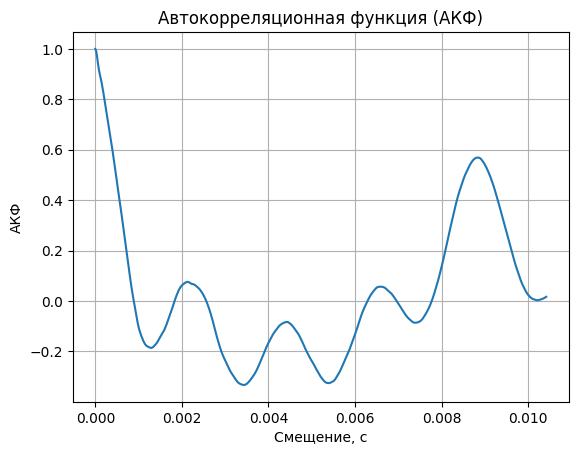

In [235]:

acf_vals = sm_acf(x, nlags=500, adjusted=True)
lags = np.arange(len(acf_vals))
plt.plot(lags / fs, acf_vals)
plt.title("Автокорреляционная функция (АКФ)")
plt.xlabel("Смещение, с")
plt.ylabel("АКФ")
plt.grid(True)
plt.show()


In [236]:

print(f"Частота основного тона речи:{1/0.0059}")

Частота основного тона речи:169.49152542372883


### 3.3 Оценка основного тона на основе ДВПФ

#### Step 1

In [237]:
def my_dtft(x, fs, f):
    x = np.asarray(x)
    n = np.arange(len(x))
    if np.isscalar(f):
        return np.abs(np.dot(x, np.exp(-2j * np.pi * f * n / fs)))
    else:
        f = np.asarray(f)
        return np.abs(np.dot(np.exp(-2j * np.pi * np.outer(f, n) / fs), x))

#### Step 2
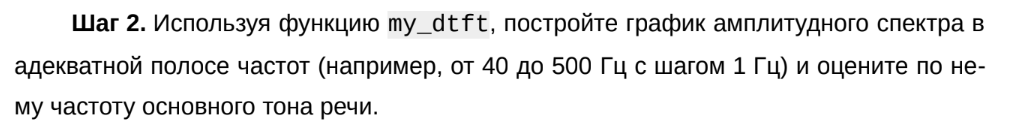

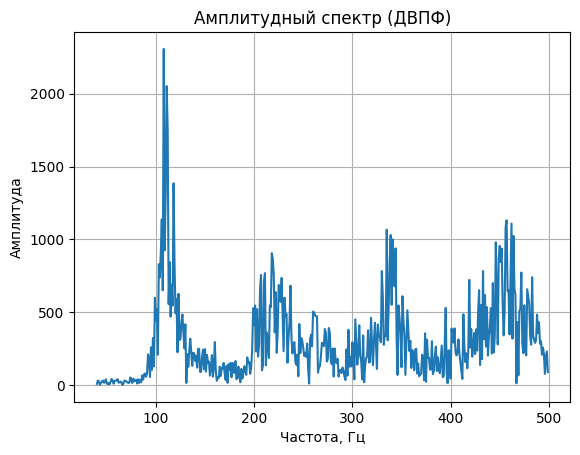

Оценка основной частоты (ДВПФ): 108 Гц


In [238]:
freqs = np.arange(40, 500, 1)
spectrum = my_dtft(x, fs, freqs)

plt.plot(freqs, spectrum)
plt.title("Амплитудный спектр (ДВПФ)")
plt.xlabel("Частота, Гц")
plt.ylabel("Амплитуда")
plt.grid(True)
plt.show()

f_dtft = freqs[np.argmax(spectrum)]
print("Оценка основной частоты (ДВПФ):", f_dtft, "Гц")

### 3.4 Оценка основного тона с помощью Google REAPER

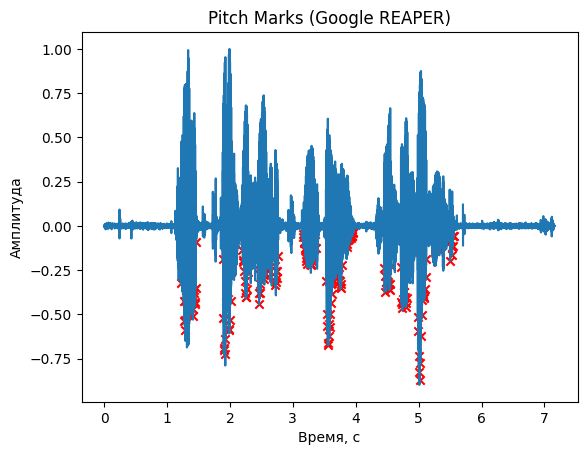

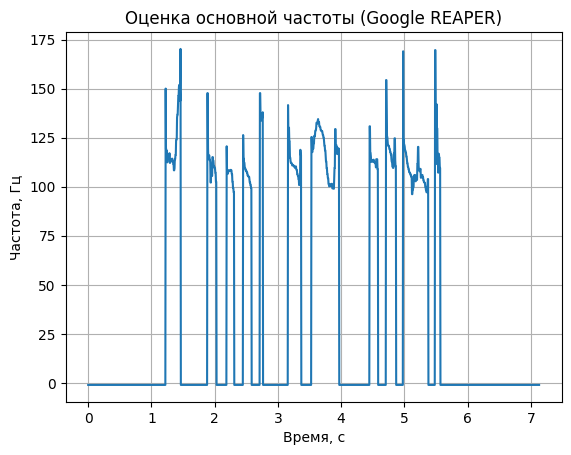

Средняя оценка основной частоты (REAPER): 115.106964 Гц


In [239]:
# Подготовка к вызову REAPER
x16 = (x * 32767).astype(np.int16)
pm_times, pm, f_times, f, _ = pyreaper.reaper(x16, fs)

# Визуализация
plt.figure()
plt.plot(t, x)
plt.scatter(pm_times[pm == 1], x[(pm_times * fs).astype(int)][pm == 1], color='red', marker='x')
plt.title("Pitch Marks (Google REAPER)")
plt.xlabel("Время, с")
plt.ylabel("Амплитуда")
plt.show()

plt.figure()
plt.plot(f_times, f)
plt.title("Оценка основной частоты (Google REAPER)")
plt.xlabel("Время, с")
plt.ylabel("Частота, Гц")
plt.grid(True)
plt.show()

f_reaper = np.mean(f[f > 0])
print("Средняя оценка основной частоты (REAPER):", f_reaper, "Гц")